# Starlink Launch Event
Create a plot for a Starlink space event.
Select a Starlink launch event from the database, output an overview about the objects from this launch and create a altitude plot. As a representative for the altitude the semimajor axis is used.

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange, tqdm

from datetime import datetime
import re

import pandas as pd

from satdb import DBConfig, Dbase, tools

plt.rcParams["figure.figsize"] = (15,10)

Define some constants.

Place a configuration file `satdb.yaml` in the same directory as this jupyter/ipython notebook. From this configuration file the credentials to access the database are taken from. A template for this file can be found [here](https://raw.githubusercontent.com/rzbrk/satdb/master/satdb_example.yaml).

In [121]:
## Config file
config_file = "satdb.yaml"

## Filter for the satellite constellation
sat_const_filter = "STARLINK%"

## With this filter any rideshare payload can be exluded from the plot.
## If rideshare objects shall be included, set filter to empty string ("")
#rideshare_filter = """"""
rideshare_filter = """name like 'STARLINK%' or name like 'FALCON%'"""

## Filter for launch vehicle objects. Applying this filter, the curves for
## the launch vehicle objects are drawn with red dashed lines. Set filter
## to empty string, if not wanted.
#lv_filter = """"""
lv_filter = """FALCON.*"""

## The data contains spikes. For unspiking, a moving median filter is applied
## to the data. Specify the half-width of the window.
movmedian_window_size = 5

In [123]:
config = DBConfig(config_file)
dbc = Dbase(config)
dbc.connect()

Access the database and retrieve a list of Starlink launch events. Later, a specific launch event can be selected for further analysis.

In [112]:
sql = """select distinct(substr(obj_id, 1, 8)), launch_date from metadata where launch_date is not NULL and name like %s"""
launch_ids = dbc.fetchall(sql, (sat_const_filter,))

In [113]:
# Create and show a pandas dateframe
ids = [sub[0] for sub in launch_ids]
l_dates = [sub[1] for sub in launch_ids]
df = pd.DataFrame([ids,l_dates])
df = df.transpose()
df.columns=['Launch ID', 'Launch Date']
df.index = range(1,len(df) + 1)
df

,Launch ID,Launch Date
1,2019-029,2019-05-24
2,2019-074,2019-11-11
3,2020-001,2020-01-07
4,2020-006,2020-01-29
5,2020-012,2020-02-17
6,2020-019,2020-03-18
7,2020-025,2020-04-22
8,2020-035,2020-06-04
9,2020-038,2020-06-13
10,2020-055,2020-08-07


### Select launch event
Select a launch id (YYYY-NNN) from the list above to proceed with

In [114]:
id_sel = "2020-070"

Overview about all the objects from the launch without rideshare objects

In [115]:
sql = """select launch_date from metadata where launch_date is not null and obj_id like %s limit 1"""
launch_date = dbc.fetchone(sql, (id_sel + "%",))[0]

sql = """select distinct(norad) from metadata where obj_id like %s"""
if rideshare_filter != "":
    sql += (
        "and ("
        + rideshare_filter
        + ")"
        )
obj = dbc.fetchall(sql, (id_sel + "%",))

In [116]:
# Initialize some lists
norads = []
obj_ids = []
names = []
decay_dates = []

# Loop over the objects from the database query above and retrieve metadata/attributes for each object
n_obj = len(obj)

for i in trange(n_obj):
    o = obj[i]

    norads.append(o[0])
    sql = """select obj_id, name, decay_date from metadata where epoch=(select max(epoch) from metadata where norad = %s) and norad = %s"""
    md_o = dbc.fetchall(sql, (o[0], o[0],))[0]
    
    obj_ids.append(md_o[0])
    names.append(md_o[1])
    if md_o[2] is not None:
        decay_dates.append(md_o[2].strftime("%Y-%m-%d"))
    else:
        decay_dates.append('./.')

# Create and show a pandas dataframe
df = pd.DataFrame([norads, obj_ids, names, decay_dates])
df = df.transpose()
df.columns=['NORAD', 'Object ID', 'Name', 'Decay Date']
pd.set_option('display.max_rows', None)
df.index = range(1,len(df) + 1)
df
    

  0%|          | 0/65 [00:00<?, ?it/s]

,NORAD,Object ID,Name,Decay Date
1,46532,2020-070A,STARLINK-1644,./.
2,46533,2020-070B,STARLINK-1648,./.
3,46534,2020-070C,STARLINK-1659,./.
4,46535,2020-070D,STARLINK-1663,./.
5,46536,2020-070E,STARLINK-1668,./.
6,46537,2020-070F,STARLINK-1672,./.
7,46538,2020-070G,STARLINK-1678,./.
8,46539,2020-070H,STARLINK-1684,./.
9,46540,2020-070J,STARLINK-1685,./.
10,46541,2020-070K,STARLINK-1687,./.


Create an altitude plot for all objects of the selected launch event

  0%|          | 0/65 [00:00<?, ?it/s]

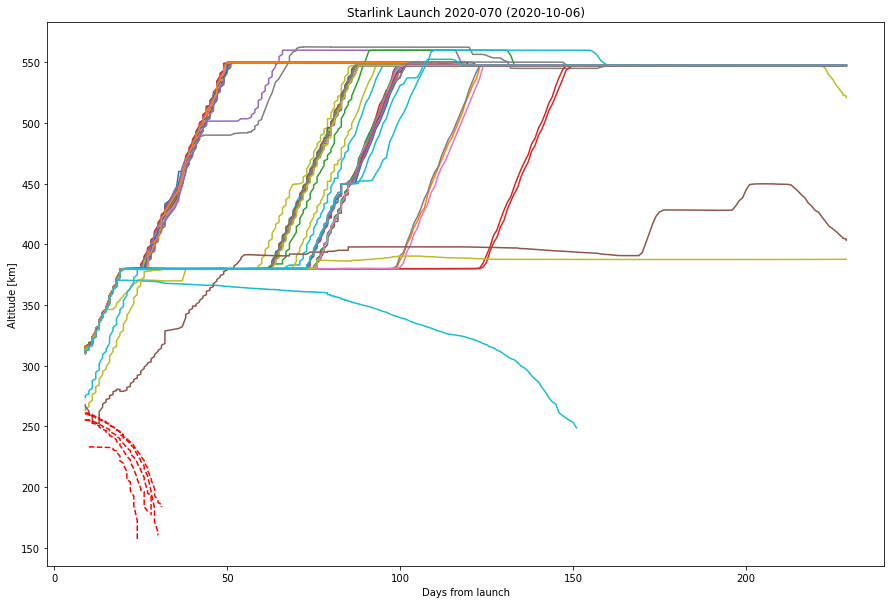

In [122]:
n_obj = len(obj)

for i in trange(n_obj):
    o = obj[i]
    
    # Get name
    sql = """select name from metadata where epoch=(select max(epoch) from metadata where norad = %s) and norad = %s"""
    name = dbc.fetchone(sql, (o[0], o[0],))[0]
    
    # Create empty arrays
    t = []
    sma = []
    sql = """select epoch, semimajor_axis from orbelem where norad = %s"""
    data = dbc.fetchall(sql, (o[0],))
    for d in data:
        dt = d[0] - launch_date
        t.append(dt.days)
        sma.append(d[1] - 6378.)
        
    # Apply moving median filter
    sma = tools.movmedian(sma, movmedian_window_size)
    
    # Starlinks/Rideshare Payloads: automatic color and solid lines
    # Falcon 9 R/B or debris: red dashed lines
    if (lv_filter != "" and re.match(lv_filter, name)):
        linestyle = "r--"
    else:
        linestyle = "-"
        
    plt.plot(t, sma, linestyle, label = name)
    plt.xlabel("Days from launch")
    plt.ylabel("Altitude [km]")
    plt.title("Starlink Launch "  + id_sel + " (" + launch_date.strftime("%Y-%m-%d") + ")")
    #plt.legend()
        